In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, OneHotEncoder, IDF, StringIndexer, VectorAssembler, RegexTokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when, col
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# Initialize Spark session
spark = SparkSession.builder \
.appName("SimplifiedClassificationModeling") \
.getOrCreate()

In [0]:
# Read the cleaned data
sdf = spark.read.parquet("s3://amazon-reviews-ma/raw/cleaned_amazon_reviews_us_Apparel_v1_00.parquet")

In [0]:
# Feature Engineering starts here
sdf = sdf.withColumn("label", when(col("star_rating") > 3, 
1).otherwise(0).cast(DoubleType()))
sampled_sdf = sdf.sample(withReplacement=False, fraction=0.3, seed=42)

In [0]:
# Text processing for 'clean_review_body'
bodyTokenizer = RegexTokenizer(inputCol="clean_review_body", 
outputCol="tokenized_body", pattern="\\W")
bodyRemover = StopWordsRemover(inputCol="tokenized_body", outputCol="filtered_body")
bodyHashingTF = HashingTF(inputCol="filtered_body", outputCol="body_features", 
numFeatures=1000)

In [0]:
# Text processing for 'clean_review_headline'
headlineTokenizer = RegexTokenizer(inputCol="clean_review_headline", 
outputCol="tokenized_headline", pattern="\\W")
headlineRemover = StopWordsRemover(inputCol="tokenized_headline", 
outputCol="filtered_headline")
headlineHashingTF = HashingTF(inputCol="filtered_headline", 
outputCol="headline_features", numFeatures=1000)

In [0]:
# Assemble features
assembler = VectorAssembler(inputCols=["body_features", "headline_features"], 
outputCol="final_features")

In [0]:
# Logistic Regression Model
classifier = LogisticRegression(featuresCol="final_features", labelCol="label")

In [0]:
# Create a Pipeline
pipeline = Pipeline(stages=[bodyTokenizer, bodyRemover, bodyHashingTF, 
headlineTokenizer, headlineRemover, headlineHashingTF, 
assembler, classifier])

In [0]:
# Split data
train_data, test_data = sampled_sdf.randomSplit([0.8, 0.2], seed=42)

In [0]:
# Fit the model
model = pipeline.fit(train_data)

In [0]:
# Making predictions
predictions = model.transform(test_data)

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluating the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
roc_auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(roc_auc))

Test Area Under ROC: 0.9437150660093738


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
# Accuracy, Precision, Recall, and F1 Score
evaluator = MulticlassClassificationEvaluator(labelCol="label", 
predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: 
"weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)


Accuracy:  0.8981925415884752
Precision:  0.8956481411683637
Recall:  0.8981925415884751
F1 Score:  0.8958632165565048


In [0]:
# Confusion Matrix
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[ 62705.  23280.]
 [ 12797. 255583.]]


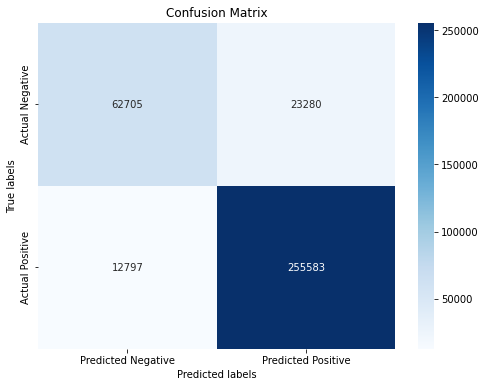

In [0]:
#Visualization of the confusion matrix:
TN, FP, FN, TP = confusion_matrix.ravel()
import pandas as pd
conf_matrix_df = pd.DataFrame(confusion_matrix, 
index=["Actual Negative", "Actual Positive"], 
columns=["Predicted Negative", "Predicted Positive"])
# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [0]:
# Saving the model to S3
model.write().overwrite().save("s3://amazon-reviews-ma/models/myAmazonLogisticRegressionModel1")